## MiniVGGNet CNN (TensorFlow + Keras)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import time

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### CIFAR 10 Dataset

In [2]:
print("[INFO] loading CIFAR-10 data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# normalize images (scale between 0 and 1)
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

[INFO] loading CIFAR-10 data...


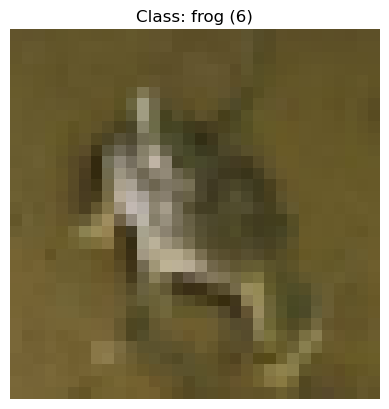

In [3]:
# test print to make sure import was  a success 
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

idx = np.random.randint(0, len(x_train))
sample_image = x_train[idx] 
sample_label = np.argmax(y_train[idx]) 
class_name = cifar10_classes[sample_label] 
sample_image = sample_image * 255.0 
sample_image = sample_image.astype("uint8")

plt.imshow(sample_image)
plt.title(f"Class: {class_name} ({sample_label})")
plt.axis("off")
plt.show()

In [4]:
# data augmentation for training only
train_datagen = ImageDataGenerator(
    rotation_range=10,   # Rotate images randomly
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Apply augmentation only on training data
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)

### MiniVGGNet Model

First conv block
- 2 conv layers (3x3, 32 filters)
- ReLu activation (discards noise)
- BatchNorm (normalizes activation for efficiency)
- Max Pool (downsamples dimensions)
- Dropout 25% (reduces overfitting)

Second block
- 2 conv layers (3x3, 64 filters)
- BatchNorm
- MaxPool
- Dropout 25%

Final
- flatten (1D vector)
- FC (512 neurons, 64 feature maps * 8x8 spacial dimensions)
- Batch norm (for FC)
- Droupout 50%
- Final FC (with number of classes)

In [5]:
def MiniVGGNet():
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # second conv block
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # FC Layers
        Flatten(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),

        # output Layer (10 classes for CIFAR-10)
        Dense(10, activation="softmax")
    ])

    return model

model = MiniVGGNet()

In [6]:
# compile
print ("[INFO] compiling model ... ")
opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.01 / 40)
#model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# prints summary
model.summary()

[INFO] compiling model ... 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                            

### Training
Prints info on each Epoch

In [7]:
# train model
epochs = 40
batch_size = 64

print("Training Model (MiniVGGNet)...")
start_time = time.time()

# train
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(x_test, y_test),
    batch_size=batch_size,
    verbose=1  
)

total_time = (time.time() - start_time) / 60
print(f"Total training time: {total_time:.2f} minutes")

Training Model (MiniVGGNet)...
Epoch 1/40
782/782 [==============================] - 36s 40ms/step - loss: 1.8383 - accuracy: 0.3957 - val_loss: 1.3993 - val_accuracy: 0.5158
Epoch 2/40
782/782 [==============================] - 33s 43ms/step - loss: 1.3858 - accuracy: 0.5134 - val_loss: 1.0992 - val_accuracy: 0.6171
Epoch 3/40
782/782 [==============================] - 29s 37ms/step - loss: 1.2188 - accuracy: 0.5694 - val_loss: 1.0629 - val_accuracy: 0.6238
Epoch 4/40
782/782 [==============================] - 28s 36ms/step - loss: 1.0990 - accuracy: 0.6109 - val_loss: 1.0287 - val_accuracy: 0.6457
Epoch 5/40
782/782 [==============================] - 28s 35ms/step - loss: 1.0182 - accuracy: 0.6375 - val_loss: 0.9611 - val_accuracy: 0.6655
Epoch 6/40
782/782 [==============================] - 28s 36ms/step - loss: 0.9671 - accuracy: 0.6586 - val_loss: 0.8716 - val_accuracy: 0.6961
Epoch 7/40
782/782 [==============================] - 29s 37ms/step - loss: 0.9313 - accuracy: 0.6723 - v

313/313 [==============================] - 1s 3ms/step - loss: 0.5899 - accuracy: 0.7966
Test accuracy: 79.66%


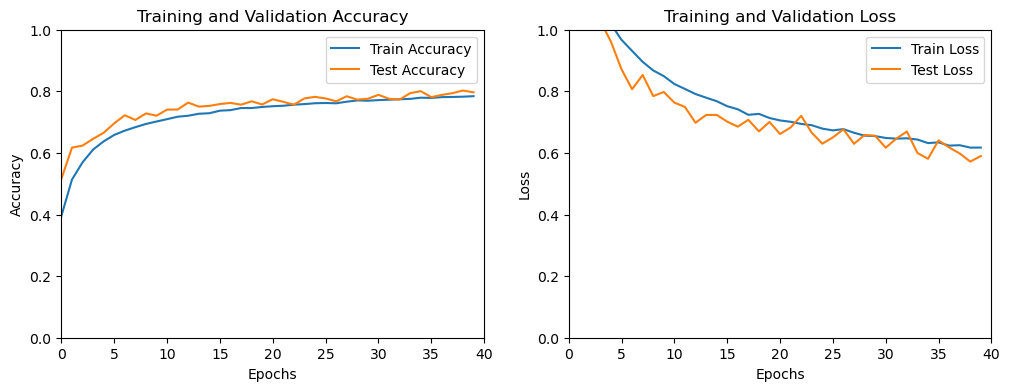

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.xlim(0, epochs)
plt.ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.xlim(0, epochs)
plt.ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()

### Inference
And model saving

In [42]:
# save
save = true

if save:
    save_dir = "./saved_models"
    model_path = os.path.join(save_dir, "minivggnet_40epoch.h5")
    model.save(model_path)
    print(f"Model saved to: {model_path}")

NameError: name 'true' is not defined

1/1 [==============================] - 0s 19ms/step


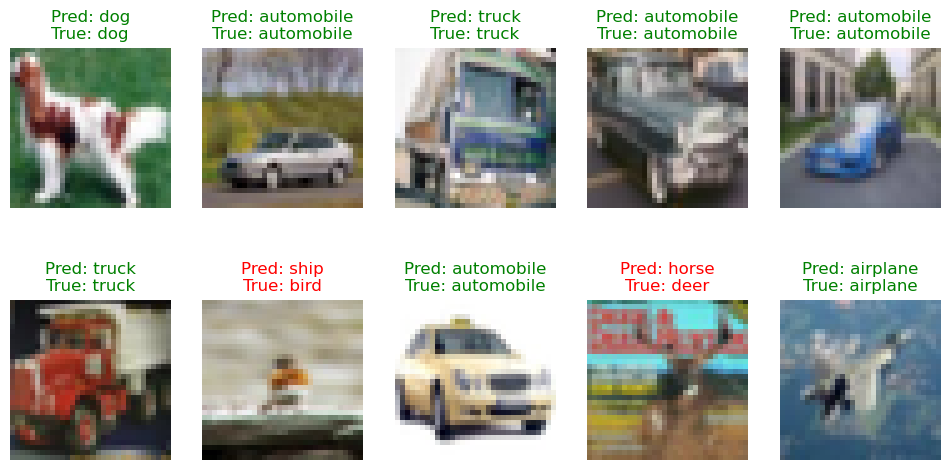

In [41]:
# choose n random sampes from the test dataset
num_samples = 10
indices = np.random.choice(len(x_test), num_samples, replace=False)
sample_images = x_test[indices]
sample_labels = y_test[indices]

# inference - predication
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(12, 6))

for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    
    # see if prediction matches the true label
    if predicted_classes[i] == true_classes[i]:
        title_color = "green"
    else:
        title_color = "red"
    
    plt.title(f"Pred: {cifar10_classes[predicted_classes[i]]}\nTrue: {cifar10_classes[true_classes[i]]}",
              color=title_color)
    
    plt.axis("off")

plt.show()